# Defining Interaction Zone


In [1]:
import io
import sys
import csv
import math
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as sklearn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import datetime
from sklearn import preprocessing 
from mat4py import loadmat
from scipy.spatial import distance
from itertools import accumulate
from matplotlib import animation
from matplotlib.colors import from_levels_and_colors
from enum import Enum

print('-- Sys version --', sys.version)

# My custom imports
import import_ipynb
import helper_functions



-- Sys version -- 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
importing Jupyter notebook from helper_functions.ipynb
-- Sys version -- 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
dist AD: 10.770329614269007
dist BC: 10.770329614269007
dist AB: 5.385164807134504
dist DC: 5.385164807134504


In [2]:
def finPointOnTheSameLineXMetersAway(pointA, pointB, metersAway):
    # Let's try to find a point along the line AD using vectors
    # https://math.stackexchange.com/questions/175896/finding-a-point-along-a-line-a-certain-distance-away-from-another-point
    
    # v = (X1, y1) - (x0 - y0)
    v = np.array(pointA) - np.array(pointB)
    
    # Normalize this to 𝐮=(𝐯 / ||𝐯||)
    # 𝐯=(𝑣1,𝑣2) ||𝐯||= math.sqrt(𝑣1**2 + 𝑣2**2)
    v1 = v[0]
    v2 = v[1]
    
    _v_ = math.sqrt(v1**2 + v2**2)
    
    u = v/_v_
    
    # The point along your line at a distance 𝑑 from (𝑥0,𝑦0) is then (𝑥0,𝑦0)+𝑑𝐮
    d = metersAway
    P = np.array(pointA) + d*u
    
    #print('P ', P)
    return P

def defineBycicleInteractionZoneCoordinates():
    A, B, C, D = helper_functions.getConflictZoneCoordinates()
    #print(A, B, C, D)
    
    # Let's start with defining the North interaction zone
    # Define dots 10 meters from A, D 
    E_1 = finPointOnTheSameLineXMetersAway(A, D, helper_functions.INTERACTION_ZONE_1_LENGTH)
    F_1 = finPointOnTheSameLineXMetersAway(B, C, helper_functions.INTERACTION_ZONE_1_LENGTH)
    
    # Manually adjust the IZ border to be approximately as wide as trajectories
    # (because we will use the center of it to calculate the distance from IZ)
    E = finPointOnTheSameLineXMetersAway(E_1, F_1, -2)
    F = finPointOnTheSameLineXMetersAway(E_1, F_1, -10)
    
    '''
    # Bicycle interaction zone border EF 20m from CZ
    E_2 = finPointOnTheSameLineXMetersAway(E_1, F_1, -2)
    F_2 = finPointOnTheSameLineXMetersAway(E_1, F_1, -10)
    
    # Create imaginary dots 5 meters from E_2 and F_2
    # Tyherefore, the trajectory in the cenetr of pedestrian road will be 10+2,5m long
    E_3 = finPointOnTheSameLineXMetersAway(E_2, A, 5) 
    F_3 = finPointOnTheSameLineXMetersAway(F_2, B, 5)
    
    # Now create final E 3,5 meters from the F_3
    # And final F 3,5 meters from the F_2
    # Now the meadium bicycle trajectory (in the middle of pedestrian road) will be 10+2,5+7,5=20 meters
    E = finPointOnTheSameLineXMetersAway(F_3, E_3, 3.5)
    F = finPointOnTheSameLineXMetersAway(F_2, E_2, 3.5)
    '''
    
    G_1 = finPointOnTheSameLineXMetersAway(D, A, helper_functions.INTERACTION_ZONE_1_LENGTH)
    H = finPointOnTheSameLineXMetersAway(C, B, helper_functions.INTERACTION_ZONE_1_LENGTH)
    
    G = finPointOnTheSameLineXMetersAway(G_1, H, -2)
    
    # Define also the leftmost IZ border in the soth of CZ
    # MN
    
    # Let's use the center of AB and CD for that
    AB_center = helper_functions.getCenterOfAB()
    CD_center = helper_functions.getCenterOfCD()
    
    
    # 5 meters from CZ - in the middle of trajectories so exactly 5m from the CD_center
    #M_1 = finPointOnTheSameLineXMetersAway(CD_center, AB_center, 5)
    #N_1 = finPointOnTheSameLineXMetersAway(C, B, 5)
    
    # Let's move M abit to the north to cover the whole trajectories
    M_1 = finPointOnTheSameLineXMetersAway(CD_center, AB_center, 5-1.5) # 3.5m
    N_1 = finPointOnTheSameLineXMetersAway(C, B, 5-1.5) # 3.5m
    
    M_2 = finPointOnTheSameLineXMetersAway(CD_center, AB_center, 5+1.5) # 6.5m
    N_2 = finPointOnTheSameLineXMetersAway(C, B, 5+1.5) # 6.5m
    
    # Now we find new points that are on the same line as M_1 N_1 
    M = finPointOnTheSameLineXMetersAway(M_1, N_1, 5)
    N = finPointOnTheSameLineXMetersAway(M_2, N_2, 5)
      
    return E, F, G, H, M, N


def defineVehicleInteractionZoneCoordinates():
    A, B, C, D = helper_functions.getConflictZoneCoordinates()

    # Let's start with defining the North interaction zone
    # Define dots 10 meters from A, B 
    I = finPointOnTheSameLineXMetersAway(A, B, helper_functions.VEHICLE_INTERACTION_ZONE_LENGTH)
    L_1 = finPointOnTheSameLineXMetersAway(C, D, helper_functions.VEHICLE_INTERACTION_ZONE_LENGTH)
    
    K_1 = finPointOnTheSameLineXMetersAway(B, A, helper_functions.VEHICLE_INTERACTION_ZONE_LENGTH)
    J = finPointOnTheSameLineXMetersAway(D, C, helper_functions.VEHICLE_INTERACTION_ZONE_LENGTH)
    

    # Let's move the KL a bit down by adjusting y coordinate
    K = np.array([K_1[0], K_1[1] - 3])
    L = np.array([L_1[0], L_1[1] - 3])
    
    # Let's use the center of AB and CD for that
    AD_center = helper_functions.getCenterOfAD()
    BC_center = helper_functions.getCenterOfBC()
    
    
    # Let's move O abit to the north to cover the whole trajectories
    #O_1 = finPointOnTheSameLineXMetersAway(BC_center, AD_center, 5-1.5) # 3.5m
    O_1 = finPointOnTheSameLineXMetersAway(BC_center, AD_center, 5-1) # 3.5m
    P_1 = finPointOnTheSameLineXMetersAway(C, D, 5-1) # 3.5m
    
    O_2 = finPointOnTheSameLineXMetersAway(BC_center, AD_center, 5+4) # 6.5m
    P_2 = finPointOnTheSameLineXMetersAway(C, D, 5+4) # 6.5m
    
    O = finPointOnTheSameLineXMetersAway(P_1, O_1, 1)
    P = finPointOnTheSameLineXMetersAway(P_2, O_2, 1)
    
      
    return I, J, K, L, O, P




In [3]:
defineBycicleInteractionZoneCoordinates()


(array([ 1.57086015, 16.54198556]),
 array([ 8.99867367, 13.57086015]),
 array([ -9.85695338, -12.02754826]),
 array([ -6.71390676, -13.28476691]),
 array([-11.44225082,  -4.39271504]),
 array([-12.55642285,  -7.17814511]))

In [4]:
defineVehicleInteractionZoneCoordinates()

(array([-22.56953382,  15.42781353]),
 array([-26.56953382,   5.42781353]),
 array([19.56953382, -4.42781353]),
 array([ 15.56953382, -14.42781353]),
 array([ 0.34251609, -6.4140394 ]),
 array([ 4.98489954, -8.27099278]))

In [5]:
def drawBycicleInteractionZone():
    E, F, G, H, M, N = defineBycicleInteractionZoneCoordinates()
    plt.plot([E[0], F[0]], [E[1], F[1]], color='red', linewidth=1)
    plt.text(E[0], E[1], 'E')
    plt.text(F[0], F[1], 'F')
    
    plt.plot([G[0], H[0]], [G[1], H[1]], color='red', linewidth=1)
    plt.text(G[0], G[1], 'G')
    plt.text(H[0], H[1], 'H')
    
    plt.plot([M[0], N[0]], [M[1], N[1]], color='red', linewidth=1)
    plt.text(M[0], M[1], 'M')
    plt.text(N[0], N[1], 'N')
    
def drawVehicleInteractionZone():
    I, J, K, L, O, P = defineVehicleInteractionZoneCoordinates()
    
    plt.plot([I[0], J[0]], [I[1], J[1]], color='blue', linewidth=1)
    plt.text(I[0], I[1], 'I')
    plt.text(J[0], J[1], 'J')
    
    plt.plot([K[0], L[0]], [K[1], L[1]], color='blue', linewidth=1)
    plt.text(K[0], K[1], 'K')
    plt.text(L[0], L[1], 'L')
    
    plt.plot([O[0], P[0]], [O[1], P[1]], color='blue', linewidth=1)
    plt.text(O[0], O[1], 'O')
    plt.text(P[0], P[1], 'P')
    
def drawInteractionAndConflictZones():
    plt.grid(b=True, color='#D3D3D3') # which='minor'
    plt.minorticks_on()
    plt.title('Conflict zone = magenta, Bycicle interaction zone = red, Vehicle interaction zone = blue')
    plt.xlabel('Coordinates')
    plt.ylabel('Coordinates')
    helper_functions.drawConflictZone()
    drawBycicleInteractionZone()
    drawVehicleInteractionZone()
    
    

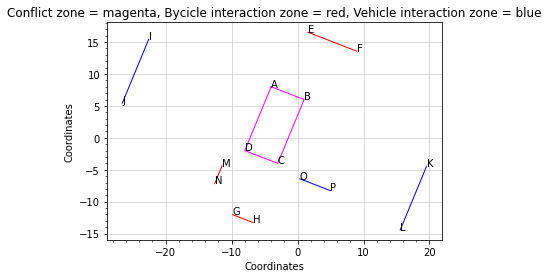

In [6]:
plt.figure()
drawInteractionAndConflictZones()
plt.show()


##### Explenation of how MN was defined:

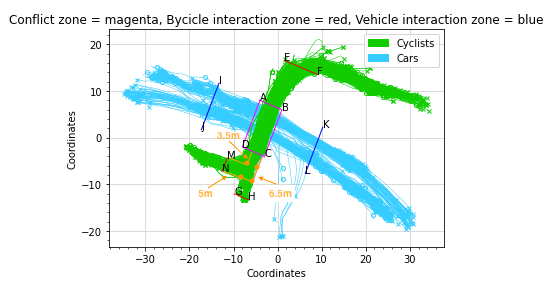

In [7]:
# Set threshold of speed less than speed_treshold km/h 
def didAgentsSpeedLower(speedOverTime, speed_treshold = 5):
    for index, speed in enumerate(speedOverTime):
        if (index != 0):
            if speed <= speed_treshold :
                return True, index # returns also at what moment the speed dropped
    return False, None


def plotTrajectories(instances, showSpeedChange=False, speed_treshold=10):
    # Create a figure
    plt.figure()
    plt.title('Trajectories')
    
    
    green = '#00cc00'
    blue = '#33ccff'
    red = '#FF0000'

    # For each instance
    for instance in instances:
        #print(key)
        #instance = instances[key] 

        id, t, ts, x, y, v, type, timeDiff, distance_m = helper_functions.getFeatures(instance)

        # Bicycle
        if (type == 1):
            plt.plot(x, y, color=green, linewidth=0.5, label='Cyclist {}'.format(id))
            # Start of the trajectory is represented by o
            plt.plot(x[1], y[1], color=green, marker='o', markersize=4,
                     label='Cyclist {}'.format(id), fillstyle='none')
            # End of the trajectory is represented by x
            plt.plot(x[-1], y[-1], color=green, marker='x', markersize=4,
                     label='Cyclist {}'.format(id), fillstyle='none')
            
            if (showSpeedChange == True):
                didSpeedLower, atTimeStep = didAgentsSpeedLower(v, speed_treshold)
        
                if didSpeedLower == True:
                    print("Cyclist's speed lowered to", speed_treshold, "or less km/h! (id: ", id, ')')
                    plt.plot(x[atTimeStep], y[atTimeStep], color=red, marker='v', markersize=4,
                     label='Cyclist {}'.format(id), fillstyle='none')
                    
                
                    
                

        # Car
        elif (type == 2):
            plt.plot(x, y, color=blue, linewidth=0.5, label='Car {}'.format(id))
            plt.plot(x[1], y[1], color=blue, marker='o', markersize=4,
                     label='Car {}'.format(id), fillstyle='none')
            plt.plot(x[-1], y[-1], color=blue, marker='x', markersize=4,
                     label='Car {}'.format(id), fillstyle='none')
            
            if (showSpeedChange == True):
                didSpeedLower, atTimeStep = didAgentsSpeedLower(v, speed_treshold)

                if didSpeedLower == True:
                    print("Car's speed lowered to", speed_treshold, "or less km/h! (id: ", id, ')')
                    
                    plt.plot(x[atTimeStep], y[atTimeStep], color=red, marker='v', markersize=4,
                     label='Car {}'.format(id), fillstyle='none')

        else:
            print('-- Unknown agent type! --')

    # Create a plot with legend
    green_patch = mpatches.Patch(color=green, label='Bicycles')
    blue_patch = mpatches.Patch(color=blue, label='Vehicles')
    plt.legend(handles=[green_patch, blue_patch])
    
    drawInteractionAndConflictZones()
    
    # For plotting separately vehicle or bicycle IZ
    #drawVehicleInteractionZone()
    #drawBycicleInteractionZone()
    ''' 
    plt.grid(b=True, color='#D3D3D3') # which='minor'
    plt.minorticks_on()
    plt.title('Conflict zone = magenta, Bycicle interaction zone = red, Vehicle interaction zone = blue')
    plt.xlabel('Coordinates')
    plt.ylabel('Coordinates')
    helper_functions.drawConflictZone()
    '''

    plt.show()

    